In [2]:
import csv
import math

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import keras
from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.initializers import glorot_uniform
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import keras.backend as K

from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Concatenate, Activation
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file

WEIGHTS_PATH = 'https://github.com/wohlert/keras-squeezenet/releases/download/v0.1/squeezenet_weights.h5'

def _fire(x, filters, name="fire"):
    sq_filters, ex1_filters, ex2_filters = filters
    squeeze = Convolution2D(sq_filters, (1, 1), activation='relu', padding='same', name=name + "squeeze1x1")(x)
    expand1 = Convolution2D(ex1_filters, (1, 1), activation='relu', padding='same', name=name + "expand1x1")(squeeze)
    expand2 = Convolution2D(ex2_filters, (3, 3), activation='relu', padding='same', name=name + "expand3x3")(squeeze)
    x = Concatenate(axis=-1, name=name)([expand1, expand2])
    return x

def SqueezeNet(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=1000):

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Convolution2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu", name='conv1')(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1', padding="valid")(x)

    x = _fire(x, (16, 64, 64), name="fire2")
    y = _fire(x, (16, 64, 64), name="fire3")
    
    x = keras.layers.add([x,y])
    x = keras.layers.BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool3', padding="valid")(x)

    x = _fire(x, (32, 128, 128), name="fire4")
    y = _fire(x, (32, 128, 128), name="fire5")
    
    x = keras.layers.add([x,y])
    x = keras.layers.BatchNormalization()(x)   

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool5', padding="valid")(x)

    x = _fire(x, (48, 192, 192), name="fire6")
    y = _fire(x, (48, 192, 192), name="fire7")
    
    x = keras.layers.add([x,y])
    x = keras.layers.BatchNormalization()(x)

    x = _fire(x, (64, 256, 256), name="fire8")
    y = _fire(x, (64, 256, 256), name="fire9")
    
    x = keras.layers.add([x,y])
    x = keras.layers.BatchNormalization()(x)

    if include_top:
        x = Dropout(0.5, name='dropout9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = AveragePooling2D(pool_size=(13, 13), name='avgpool10')(x)
        x = Flatten(name='flatten10')(x)
        x = Activation("softmax", name='softmax')(x)
    else:
        if pooling == "avg":
            x = GlobalAveragePooling2D(name="avgpool10")(x)
        else:
            x = GlobalMaxPooling2D(name="maxpool10")(x)

    model = Model(img_input, x, name="squeezenet")

    if weights == 'imagenet':
        weights_path = get_file('squeezenet_weights.h5',
                                WEIGHTS_PATH,
                                cache_subdir='models')

        model.load_weights(weights_path)

    return model

prices = []
image_paths = []

data_path = "../datasets/cars_im/"
with open("../datasets/cars_filtered.csv") as file:
    reader = csv.reader(file)
    i = -1
    for row in reader:
        i += 1
        index = row[0]
        name = row[1]
        msrp = int(row[3])
        
        image_path = data_path + index + '.jpg'
        image_paths.append(image_path)
        prices.append(int(msrp))

train_indices = np.load("cars_train_indices.npy")
test_indices = np.load("cars_test_indices.npy")
print(train_indices.shape)
print(test_indices.shape)

from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

def image_generator(indices, batch_size):

    num_batches = int(len(indices) / batch_size)
    
    while True:
        for batch_i in range(num_batches):
            if batch_i == num_batches - 1:
                # special case: return as many as possible
                start_i = batch_i * batch_size
                batch_indices = indices[start_i:]
                
                X = np.zeros((len(batch_indices), 224, 224, 3))
                Y = np.zeros((len(batch_indices), 1))
            
            else:
                start_i = batch_i * batch_size
                end_i = start_i + batch_size

                batch_indices = indices[start_i:end_i]

                X = np.zeros((batch_size, 224, 224, 3))
                Y = np.zeros((batch_size, 1))
            
            for i, index in enumerate(batch_indices):
                img = image.load_img(image_paths[index], target_size=(224, 224))
                X[i, :, :, :] = image.img_to_array(img)                
                Y[i] = prices[index]
            
            # use vgg16 preprocessing
            X = preprocess_input(X)
#             X = seq.augment_images(X)
            
            yield (X, Y)

# Hyperparameters

num_settings = 1

hp_dropout = [0.5] * num_settings

#RMSprop
hp_lr = [0.001] * num_settings
hp_rho = [0.9] * num_settings
hp_epsilon = [1e-07] * num_settings
hp_decay = [0.0] * num_settings

# Number of hidden units
hp_hidden = [256] * num_settings

# Minibatch size
hp_mbsize = [64] * num_settings

num_epochs = 1000


(1330,)
(147,)


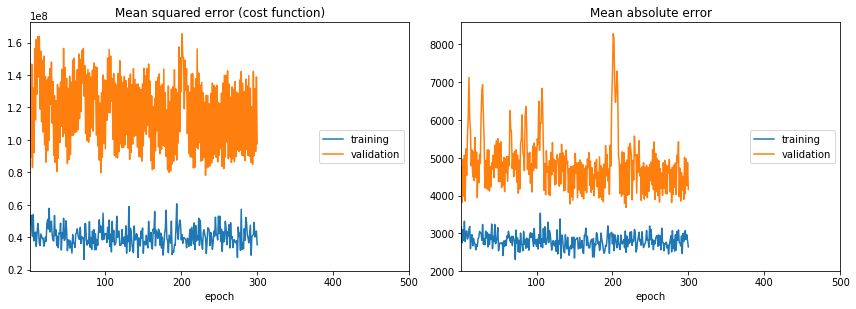

In [3]:
from livelossplot import PlotLossesKeras

# store the results of each setting
train_losses = np.zeros(num_settings)
dev_losses = np.zeros(num_settings)

for setting in range(num_settings):
    model = SqueezeNet(include_top=True)
    
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()
    
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Convolution2D(256, (1, 1), padding='valid', name='top_conv', input_shape=(model.layers[-1].output_shape[1:])))
    top_model.add(AveragePooling2D(pool_size=(5, 5), name='top_avgpool'))
    top_model.add(Flatten(input_shape=(model.layers[-1].output_shape[1:]),name='top_flatten'))
    top_model.add(Dropout(hp_dropout[setting], name='top_dropout'))
    top_model.add(Dense(hp_hidden[setting], activation='relu', kernel_initializer='glorot_uniform', name='top_dense'))
    top_model.add(Dense(1, activation='linear', name='output', kernel_initializer='glorot_uniform'))
    
    # add the model on top of the convolutional base
    new_model = Model(inputs= model.input, outputs = top_model(model.layers[-1].output))
#     new_model.summary()
    
    new_model = load_model("E:/output/cars-cnn-PriceNet-Reg-Aug/00200.hdf5")
    
    # RMSprop optimizer
#     new_model.compile(loss='mean_squared_error',
#                       optimizer=optimizers.RMSprop(
#                               lr=hp_lr[setting], 
#                               rho=hp_rho[setting], 
#                               epsilon=hp_epsilon[setting], 
#                               decay=hp_decay[setting]))
    new_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    
    
    checkpoint_path = 'E:/output/cars-cnn-PriceNet-Reg-Aug/{epoch:05d}.hdf5'
    
    # keep a checkpoint
    checkpoint = ModelCheckpoint(checkpoint_path, period=5)
    
    
    minibatch_size = hp_mbsize[setting]

    train_steps = math.ceil(len(train_indices) / minibatch_size)
    test_steps = math.ceil(len(test_indices) / minibatch_size)

    # fine-tune the model
    history = new_model.fit_generator(
        image_generator(test_indices, minibatch_size),
        steps_per_epoch=test_steps,
        epochs=500,
        validation_data=image_generator(test_indices, minibatch_size),
        nb_val_samples=test_steps,
        initial_epoch=200,
        callbacks=[checkpoint, PlotLossesKeras()])
    
   
    print("==========")